<a href="https://github.com/data-for-good-grenoble/atelier-OFF" target="_blank"><img src="image_meetup_off.png" width=500px/></a>

# 🍫 Atelier d'exploration des données d'Open Food Facts - Meetup Python Grenoble 🐍

*Jeudi 27 juin 2024 - 19h - <a href="https://turbine.coop/" target="_blank">La Turbine</a> - Grenoble*

**Notations :**

▶️ : le code peut être exécuté sans modification

💻 : le code doit être créé ou modifié

___

▶️ Importer les **bibliothèques nécessaires** à l'activité

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## 🎣 PARTIE N°1 : Récupérer un produit de la base de données d'Open Food Facts et classer les produits par similitudes

Le modèle de recommandation que l'on construit se base sur des **similitudes des caractéristiques des produits** puis en sélectionnant les produits avec le **meilleur nutriscore**. D'autres **approches par catégories de produits** sont possibles. 

▶️ Récupérer **500 produits** de la **catégorie "snacks"**

In [19]:
def get_open_food_facts_data(category, page_size=100, num_pages=5):
    base_url = "https://world.openfoodfacts.org/cgi/search.pl"
    products = []
    for page in range(1, num_pages + 1):
        params = {
            'action': 'process',
            'tagtype_0': 'categories',
            'tag_contains_0': 'contains',
            'tag_0': category,
            'page_size': page_size,
            'page': page,
            'json': 1
        }
        response = requests.get(base_url, params=params)
        data = response.json()
        products.extend(data.get('products', []))
    return products

category = 'snacks'
data = get_open_food_facts_data(category)
df = pd.json_normalize(data)
df

,_id,_keywords,added_countries_tags,additives_debug_tags,additives_n,additives_old_n,additives_old_tags,additives_original_tags,additives_prev_original_tags,additives_tags,...,images.ingredients_yi.sizes.full.h,images.ingredients_yi.sizes.full.w,images.ingredients_yi.white_magic,images.ingredients_yi.x1,images.ingredients_yi.x2,images.ingredients_yi.y1,images.ingredients_yi.y2,languages.en:yiddish,languages_codes.yi,ecoscore_extended_data.impact.likeliest_recipe.fr:lai___cr_m__en_poudre
0,7622210449283,"[35, and, au, biscuit, ble, cake, charte, choc...",[],"[en-e322i-added, en-e450-added, en-e500ii-adde...",4.0,4.0,"[en:e502, en:e450, en:e1403, en:e322]","[en:e503ii, en:e500ii, en:e450i, en:e322i]","[en:e503, en:e500, en:e450i, en:e322]","[en:e322, en:e322i, en:e450, en:e450i, en:e500...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3175680011480,"[arome, au, biscuit, colorant, de, en, et, eur...",[],[],4.0,6.0,"[en:e1403, en:e322, en:e336, en:e500, en:e503,...","[en:e322i, en:e336, en:e500, en:e503]","[en:e341, en:e504, en:e322, en:e336, en:e500, ...","[en:e322, en:e322i, en:e336, en:e500, en:e503]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3046920022651,"[70, and, bar, cacao, chocolate, cocoa, dark, ...",[],[],0.0,0.0,[],[],[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3046920029759,"[90, and, chocolate, cocoa, dark, excellence, ...",[],NaN,0.0,NaN,NaN,[],NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3046920022606,"[85, agriculture, and, bar, belgium, cacao, ch...",[],[],0.0,0.0,[],[],[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3497911119124,"[and, appetizer, beverage, bret, brittany, cer...",[],[],0.0,0.0,[],[],[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,4000607852008,"[barre, cacao, chocolat, chocolatee, confiseri...",[],[],1.0,0.0,[],[en:e322],[],[en:e322],...,393.0,2215.0,false,307.99595382462684,2522.9690881529846,1757.4718341884327,2150.4509386660447,2.0,2.0,NaN
497,3229820800325,"[ab, agriculture, and, biologique, biscuit, bj...",[],NaN,4.0,4.0,"[en:e503, en:e500, en:e1403, en:e414]","[en:e503, en:e500, en:e414, en:e392]",NaN,"[en:e392, en:e414, en:e500, en:e503]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,7622201685003,"[appetizer, colorant, conservateur, cracker, r...",[],NaN,3.0,4.0,"[en:e341, en:e503, en:e500, en:e501]","[en:e341, en:e503, en:e500]",NaN,"[en:e341, en:e500, en:e503]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


▶️ Analyser les **valeurs manquantes**

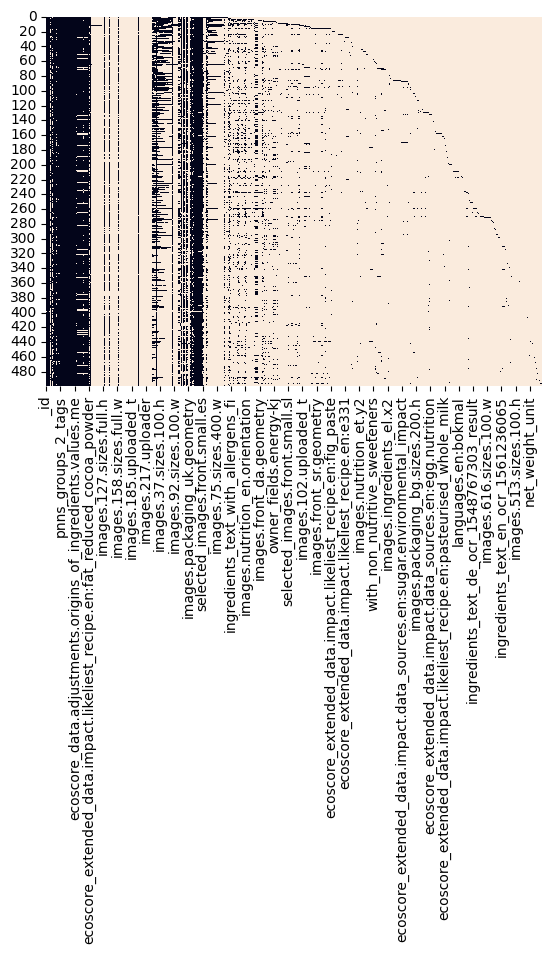

In [20]:
sns.heatmap(df.isna(), cbar=False)
plt.show()

▶️ Sélectionner les **colonnes les plus intéressantes** (5 à 10 colonnes)

In [21]:
# Sélectionner les colonnes d'intérêt
columns = ['product_name', 'nutriments.energy_100g', 'nutriments.fat_100g',
           'nutriments.carbohydrates_100g', 'nutriments.proteins_100g', 'nutriments.sugars_100g',
           'nutriments.salt_100g']
df = df[columns]
# Renommer les colonnes pour simplifier
df.columns = ['product_name', 'energy', 'fat', 'carbohydrates', 'proteins', 'sugars', 'salt']

▶️ Traiter les **valeurs manquantes**

In [22]:
df = df.dropna()

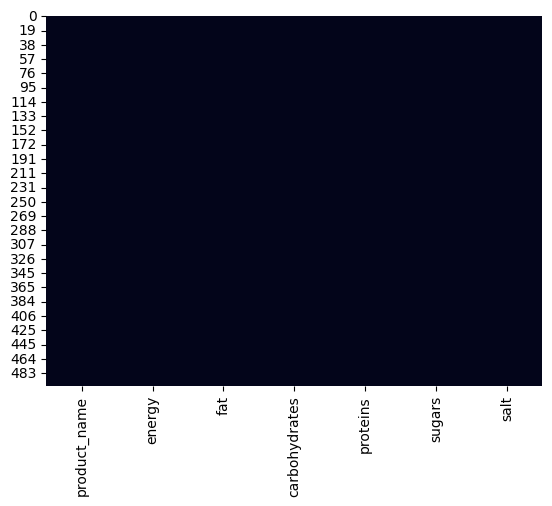

In [23]:
sns.heatmap(df.isna(), cbar=False)
plt.show()

▶️ **Normaliser** les données

In [24]:
# Normaliser les données
nutritional_data = df[['energy', 'fat', 'carbohydrates', 'proteins', 'sugars', 'salt']]
normalized_data = (nutritional_data - nutritional_data.mean()) / nutritional_data.std()

▶️ Calculer la **matrice de similarité cosinus**

In [25]:
# Calculer la similarité cosinus
similarity_matrix = cosine_similarity(normalized_data)

▶️ Créer le **moteur de recommandation** de produits similaires

In [26]:
def recommend_products(product_name, df, similarity_matrix, top_n=5):
    matching_products = df[df['product_name'].str.contains(product_name, case=False, na=False)]
    if matching_products.empty:
        print(f"Produit '{product_name}' non trouvé.")
        return pd.DataFrame()
    product_index = matching_products.index[0]
    similarity_scores = list(enumerate(similarity_matrix[product_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_products_indices = [i[0] for i in similarity_scores[1:top_n + 1]]
    return df.iloc[similar_products_indices][['product_name', 'energy', 'fat', 'carbohydrates', 'proteins', 'sugars', 'salt']]

▶️ Tester le moteur de recommandation sur un **exemple de produit**

In [27]:
# Exemple de recommandation
product_name = "Crackers"
recommended_products = recommend_products(product_name, df, similarity_matrix, top_n=5)
print(recommended_products)

                              product_name  energy   fat  carbohydrates  \
366       BelVita - Petit déjeuner Tartiné  1926.0  16.0           69.0   
22                  Biscuits goût chocolat  1944.0  17.0           69.0   
355  Duo Fourré Goût Chocolat 🍫 Noisette 🥜  1880.0  15.0           67.2   
497         Biscuits fourrés chocolat noir  2004.0  20.0           65.0   
25                 Fourrés - Chocolat Noir  2017.0  20.0           65.0   

     proteins  sugars   salt  
366      7.40    26.0  0.560  
22       6.50    30.0  0.470  
355      7.51    27.7  0.514  
497      7.10    27.0  0.500  
25       7.60    27.0  0.490  


## 🌍 PARTIE N°2 : trouver des produits avec un meilleur impact environnmental

Les données de la base de données d'Open Food Facts ont été **sélectionnées** suivant les critères suivants :

- Produits présents en **France**
- Avec un **nutriscore valide**
- Avec un **écoscore valide**
- Avec des colonnes avec **moins de 20% de données manquantes**
- Avec une sélection de **colonnes intéressantes**
- Avec une sélection aléatoire de **10% des données** (problèmes de temps de calculs)

___

▶️ **Récupérer les données** pré-traitées de la base de données d'Open Food Facts

In [2]:
data = pd.read_csv("OFF_dataset.csv")
data

,product_name,brands,categories,nutriscore_grade,ecoscore_grade,main_category,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,Amandes decortiquées,NaN,"Aliments et boissons à base de végétaux, Alime...",b,e,en:shelled-almonds,645.0,2699.0,49.90,3.800,21.5,4.2,21.10,0.100,0.0400
1,OssoBucco de veau,Tendre & Plus,"Plats préparés, Plats préparés à la viande, Os...",a,e,en:osso-buco,109.0,456.0,2.00,0.500,6.4,2.6,16.00,0.820,0.3280
2,Margarine,Bellasan,"Aliments et boissons à base de végétaux, Alime...",d,c,en:margarines,720.0,3012.0,80.00,23.000,0.0,0.0,0.00,0.200,0.0800
3,Cacahuètes grillées et salées,Netto,"Aliments et boissons à base de végétaux, Alime...",d,d,en:salted-peanuts,605.0,2561.0,47.50,6.400,13.8,4.1,26.90,0.830,0.3320
4,Costières de Nîmes,NaN,"Boissons, Boissons alcoolisées, Vins, Vins fra...",not-applicable,c,en:rose-wines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20307,Kiwi sungold,zespri,"Aliments et boissons à base de végétaux, Alime...",a,a,en:kiwifruits,79.0,337.0,0.28,0.065,15.8,12.3,1.02,0.007,0.0028
20308,Tajine de poulet aux fruits séchés,Léon Fargues,"Viandes et dérivés, Plats préparés, Plats prép...",c,d,en:chicken-tajine,184.0,770.0,10.00,3.600,11.0,6.8,11.00,1.100,0.4400
20309,Chocolat noir 72% cacao,Carrefour,"Snacks, Snacks sucrés, Cacao et dérivés, Choco...",d,d,en:dark-chocolates-with-cocoa-nibs,584.0,2443.0,44.00,27.000,31.0,24.0,9.60,0.000,0.0000
20310,Mélange de noix de cajou et canneberges,"Alesto,Lidl","Aliments et boissons à base de végétaux, Alime...",b,d,en:cashew-nuts,468.0,1958.0,24.00,5.000,50.0,36.0,10.00,0.080,0.0320


▶️ **Remplacer les valeurs manquantes** de la colonne "brands" par "-". Vérifier le **remplissage**

In [3]:
data['brands'] = data['brands'].fillna("-")

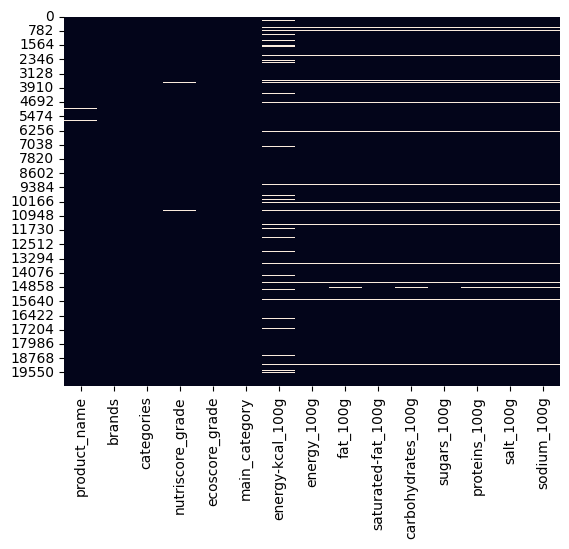

In [4]:
sns.heatmap(data.isna(), cbar=False)
plt.show()

▶️ **Supprimer les valeurs manquantes restantes** et vérifier qu'il ne reste plus de valeurs manquantes

In [5]:
data = data.dropna()

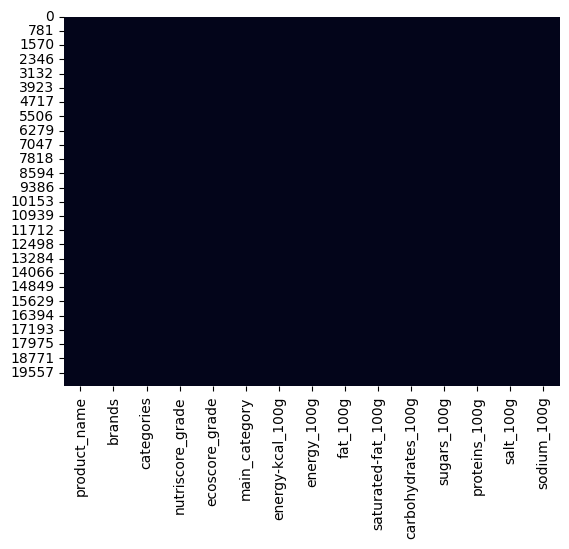

In [6]:
sns.heatmap(data.isna(), cbar=False)
plt.show()

💻 **Sélectionner les données** à prendre en compte et **normaliser ces données**

In [7]:
useful_col = [
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g'
]
# Normaliser les données
nutritional_data = data[useful_col]
normalized_data = (nutritional_data - nutritional_data.mean()) / nutritional_data.std()

▶️ Calculer la **matrice de similarité cosinus**

In [8]:
# Calculer la similarité cosinus
similarity_matrix = cosine_similarity(normalized_data)

💻 **Modifier le moteur de recommandation** de produits similaires et **tester le fonctionnement** sur différents produits

In [9]:
def recommend_products(product_name, df, similarity_matrix, top_n=5):
    matching_products = data[data['product_name'].str.contains(product_name, case=False, na=False)]
    if matching_products.empty:
        print(f"Produit '{product_name}' non trouvé.")
        return pd.DataFrame()
    product_index = matching_products.index[0]
    similarity_scores = list(enumerate(similarity_matrix[product_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_products_indices = [i[0] for i in similarity_scores[1:top_n + 1]]
    return data.iloc[similar_products_indices][['product_name', 'brands', 'ecoscore_grade', 'nutriscore_grade']]

In [10]:
product_name = "Margarine"
recommended_products = recommend_products(product_name, data, similarity_matrix, top_n=10)
print(recommended_products)

                                            product_name              brands  \
2495                       Molivo tartine et cuisson bio           Vitaquell   
7864                                           Margarine          Bonneterre   
6610   Huile De Tournesol, Bidon De 2 Litres, Marque ...                Cora   
15959                                      Graisse d'oie  Comte de la Seynie   
19277                                     MARGARINE SOJA            Provamel   
10656                                  Graisse de canard                   -   
18071                                  Graisse de canard            Larroque   
14257       Fruit d'Or Bio sans huile de palme  Demi-Sel          Fruit d'Or   
2850           Huile d'olive de Tunisie Bio extra vierge       Terra Delyssa   
19652                                      Huile d'olive    Roland monterrat   

      ecoscore_grade nutriscore_grade  
2495               b                d  
7864               b                d  